Citation: https://www.kaggle.com/code/abhilash1910/clustertransformer-topic-modelling-in-transformers

In [15]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.manifold import TSNE
import matplotlib.colors as mcolors
import gensim
from gensim.utils import simple_preprocess
from gensim.models import Phrases, phrases, ldamodel, CoherenceModel
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import spacy
import gensim.corpora as corpora
from pprint import pprint
import pyLDAvis
import pyLDAvis.gensim_models
from collections import Counter

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/Munachiso.Nwadike/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


(19579, 3)
id        0
text      0
author    0
dtype: int64


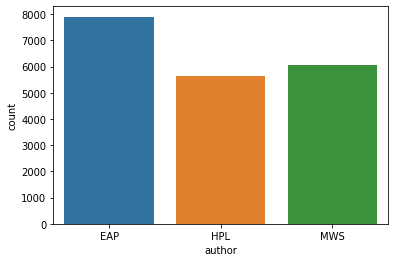

In [22]:
data_df = pd.read_csv('data/train.zip')
data_df.head()

# shape of the dataset
print(data_df.shape)

# value count for eavh author
sns.countplot(data_df['author'])

# null value
print(data_df.isnull().sum())

## Visualisation

In [23]:
data_df['Number_of_words'] = data_df['text'].apply(lambda x:len(str(x).split()))
print(data_df)

            id                                               text author  \
0      id26305  This process, however, afforded me no means of...    EAP   
1      id17569  It never once occurred to me that the fumbling...    HPL   
2      id11008  In his left hand was a gold snuff box, from wh...    EAP   
3      id27763  How lovely is spring As we looked from Windsor...    MWS   
4      id12958  Finding nothing else, not even gold, the Super...    HPL   
...        ...                                                ...    ...   
19574  id17718  I could have fancied, while I looked at it, th...    EAP   
19575  id08973  The lids clenched themselves together as if in...    EAP   
19576  id05267  Mais il faut agir that is to say, a Frenchman ...    EAP   
19577  id17513  For an item of news like this, it strikes us i...    EAP   
19578  id00393  He laid a gnarled claw on my shoulder, and it ...    HPL   

       Number_of_words  
0                   41  
1                   14  
2           

Text(0.5, 1.0, 'Frequency distribution of number of words for each text extracted')

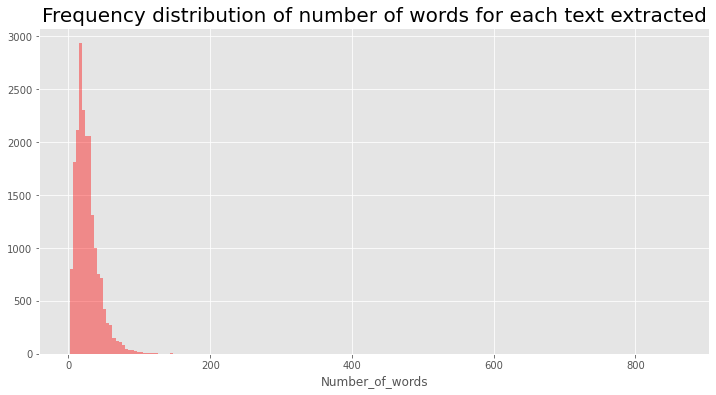

In [24]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.figure(figsize=(12,6))
sns.distplot(data_df['Number_of_words'],kde = False,color="red",bins=200)
plt.title("Frequency distribution of number of words for each text extracted", size=20)

## Data Cleaning

In [25]:
data_df['text_processed'] = data_df['text'].map(lambda x: re.sub('[,\.!?]','',x))
data_df['text_processed'] = data_df['text_processed'].map(lambda x:x.lower())
print(data_df['text_processed'].head())

0    this process however afforded me no means of a...
1    it never once occurred to me that the fumbling...
2    in his left hand was a gold snuff box from whi...
3    how lovely is spring as we looked from windsor...
4    finding nothing else not even gold the superin...
Name: text_processed, dtype: object


In [26]:
# remove all characters, number or characters
def cleanText(input_string):
    modified_string = re.sub('[^A-Za-z0-9]+', ' ', input_string)
    return(modified_string)
data_df['text_processed'] = data_df.text_processed.apply(cleanText)
data_df['text_processed'][150]

' pierre moreau tobacconist deposes that he has been in the habit of selling small quantities of tobacco and snuff to madame l espanaye for nearly four years'

In [30]:
# remove stopwords
stopWords = stopwords.words('english')
print(stopWords)

def removeStopWords(stopWords, rvw_txt):
    newtxt = ' '.join([word for word in rvw_txt.split() if word not in stopWords])
    return newtxt
data_df['text_processed'] = [removeStopWords(stopWords,x) for x in data_df['text_processed']]
print(data_df.head(3))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

## Word Cloud

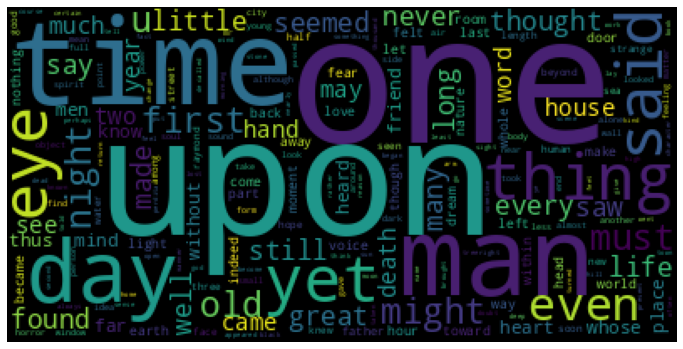

In [31]:
# join the different text together
longText = ','.join(list(data_df['text_processed'].values))
# generate the word cloud
wordcloud = WordCloud(background_color="black",
                      max_words= 600,
                      contour_width = 10,
                      contour_color = "steelblue",
                     collocations=False).generate(longText)
# visualize the word cloud
fig = plt.figure(1, figsize = (12, 12))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()


<AxesSubplot:xlabel='words', ylabel='count'>

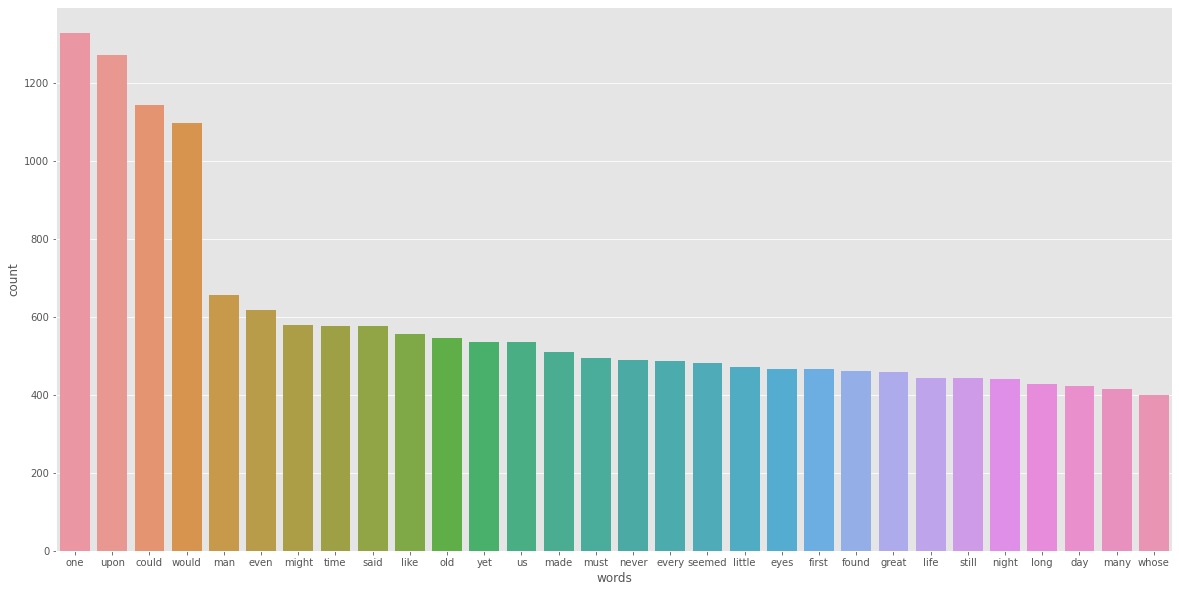

In [32]:
fig = plt.figure(1, figsize = (20,10))
# split() returns list of all the words in the string
split_it = longText.split()
# Pass the split_it list to instance of Counter class.
Counter = Counter(split_it)
#print(Counter)
# most_common() produces k frequently encountered
# input values and their respective counts.
most_occur = Counter.most_common(30)
x_df = pd.DataFrame(most_occur, columns=("words","count"))
sns.barplot(x = 'words', y = 'count', data = x_df)

## Preparing data for Topic Modelling

In [34]:
nltk.download("punkt")
# word_tokenize 
data_df["tokenized"] = data_df["text_processed"].apply(lambda x: nltk.word_tokenize(x))
data_df["tokenized"] = data_df["tokenized"].apply(lambda words: [word for word in words if word.isalnum()])
print(data_df)

[nltk_data] Downloading package punkt to
[nltk_data]     /home/Munachiso.Nwadike/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


            id                                               text author  \
0      id26305  This process, however, afforded me no means of...    EAP   
1      id17569  It never once occurred to me that the fumbling...    HPL   
2      id11008  In his left hand was a gold snuff box, from wh...    EAP   
3      id27763  How lovely is spring As we looked from Windsor...    MWS   
4      id12958  Finding nothing else, not even gold, the Super...    HPL   
...        ...                                                ...    ...   
19574  id17718  I could have fancied, while I looked at it, th...    EAP   
19575  id08973  The lids clenched themselves together as if in...    EAP   
19576  id05267  Mais il faut agir that is to say, a Frenchman ...    EAP   
19577  id17513  For an item of news like this, it strikes us i...    EAP   
19578  id00393  He laid a gnarled claw on my shoulder, and it ...    HPL   

       Number_of_words                                     text_processed  \
0         

In [37]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/Munachiso.Nwadike/nltk_data...


True

In [38]:
from nltk.stem import WordNetLemmatizer 
nltk.download('wordnet')
def word_lemmatizer(text):
    lem_text = [WordNetLemmatizer().lemmatize(i,pos='v') for i in text]
    return lem_text
data_df["lemmatized"] = data_df["tokenized"].apply(lambda x: word_lemmatizer(x))
data_df["lemmatize_joined"] = data_df["lemmatized"].apply(lambda x: ' '.join(x))
pd.set_option('display.max_colwidth', 100)
data_df.head()

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/Munachiso.Nwadike/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,id,text,author,Number_of_words,text_processed,tokenized,lemmatized,lemmatize_joined
0,id26305,"This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I m...",EAP,41,process however afforded means ascertaining dimensions dungeon might make circuit return point w...,"[process, however, afforded, means, ascertaining, dimensions, dungeon, might, make, circuit, ret...","[process, however, afford, mean, ascertain, dimension, dungeon, might, make, circuit, return, po...",process however afford mean ascertain dimension dungeon might make circuit return point whence s...
1,id17569,It never once occurred to me that the fumbling might be a mere mistake.,HPL,14,never occurred fumbling might mere mistake,"[never, occurred, fumbling, might, mere, mistake]","[never, occur, fumble, might, mere, mistake]",never occur fumble might mere mistake
2,id11008,"In his left hand was a gold snuff box, from which, as he capered down the hill, cutting all mann...",EAP,36,left hand gold snuff box capered hill cutting manner fantastic steps took snuff incessantly air ...,"[left, hand, gold, snuff, box, capered, hill, cutting, manner, fantastic, steps, took, snuff, in...","[leave, hand, gold, snuff, box, caper, hill, cut, manner, fantastic, step, take, snuff, incessan...",leave hand gold snuff box caper hill cut manner fantastic step take snuff incessantly air greate...
3,id27763,How lovely is spring As we looked from Windsor Terrace on the sixteen fertile counties spread be...,MWS,34,lovely spring looked windsor terrace sixteen fertile counties spread beneath speckled happy cott...,"[lovely, spring, looked, windsor, terrace, sixteen, fertile, counties, spread, beneath, speckled...","[lovely, spring, look, windsor, terrace, sixteen, fertile, counties, spread, beneath, speckle, h...",lovely spring look windsor terrace sixteen fertile counties spread beneath speckle happy cottage...
4,id12958,"Finding nothing else, not even gold, the Superintendent abandoned his attempts; but a perplexed ...",HPL,27,finding nothing else even gold superintendent abandoned attempts perplexed look occasionally ste...,"[finding, nothing, else, even, gold, superintendent, abandoned, attempts, perplexed, look, occas...","[find, nothing, else, even, gold, superintendent, abandon, attempt, perplex, look, occasionally,...",find nothing else even gold superintendent abandon attempt perplex look occasionally steal count...


Text(0.5, 1.0, '30 most frequent words')

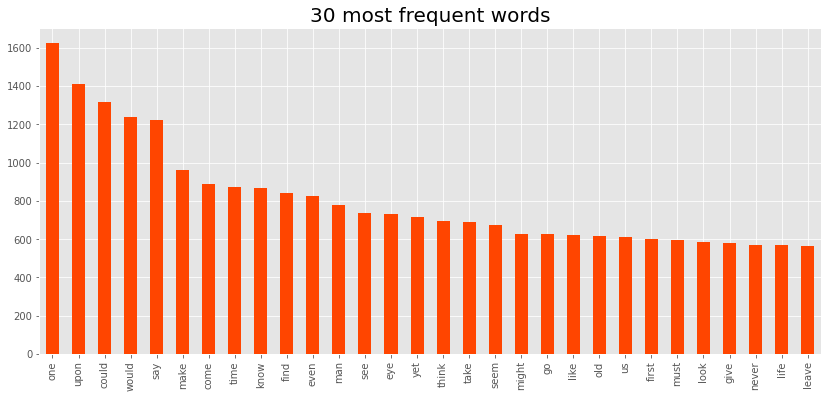

In [39]:
plt.style.use('ggplot')
plt.figure(figsize=(14,6))
freq=pd.Series(" ".join(data_df["lemmatize_joined"]).split()).value_counts()[:30]
freq.plot(kind="bar", color = "orangered")
plt.title("30 most frequent words",size=20)

In [43]:
tokens = data_df["lemmatize_joined"].apply(lambda x: nltk.word_tokenize(x))
tokens

0        [process, however, afford, mean, ascertain, dimension, dungeon, might, make, circuit, return, po...
1                                                               [never, occur, fumble, might, mere, mistake]
2        [leave, hand, gold, snuff, box, caper, hill, cut, manner, fantastic, step, take, snuff, incessan...
3        [lovely, spring, look, windsor, terrace, sixteen, fertile, counties, spread, beneath, speckle, h...
4        [find, nothing, else, even, gold, superintendent, abandon, attempt, perplex, look, occasionally,...
                                                        ...                                                 
19574                                        [could, fancy, look, eminent, landscape, painter, build, brush]
19575                                                                        [lids, clench, together, spasm]
19576                                         [mais, il, faut, agir, say, frenchman, never, faint, outright]
19577              

In [42]:
import gensim 
from gensim.models import Word2Vec 
w2v_model = Word2Vec(tokens,
                     min_count=20,
                     window=10,
                     vector_size=250,
                     alpha=0.03, 
                     min_alpha=0.0007,
                     workers = 4,
                     seed = 42)

## Model

In [44]:
dictionary = corpora.Dictionary(data_df["lemmatized"])
doc_term_matrix = [dictionary.doc2bow(rev) for rev in data_df["lemmatized"]]

LDA = gensim.models.ldamodel.LdaModel

# Build LDA model
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=3, random_state=100,
                chunksize=200, passes=100)
lda_model.print_topics()

[(0,
  '0.014*"say" + 0.009*"know" + 0.007*"upon" + 0.007*"could" + 0.007*"one" + 0.007*"make" + 0.006*"would" + 0.005*"much" + 0.005*"time" + 0.004*"well"'),
 (1,
  '0.006*"upon" + 0.006*"one" + 0.005*"come" + 0.005*"like" + 0.005*"old" + 0.005*"house" + 0.004*"look" + 0.004*"saw" + 0.004*"night" + 0.004*"could"'),
 (2,
  '0.008*"would" + 0.008*"life" + 0.006*"love" + 0.006*"yet" + 0.005*"feel" + 0.005*"death" + 0.005*"come" + 0.004*"fear" + 0.004*"even" + 0.004*"one"')]

In [45]:
# COHERENCE SCORE
coherence_model_lda = CoherenceModel(model=lda_model,
texts= data_df["lemmatized"], dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

# # Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(doc_term_matrix))  


Coherence Score:  0.477903748177535

Perplexity:  -8.617904914967152


In [47]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, doc_term_matrix, dictionary)
pyLDAvis.display(vis)

/home/Munachiso.Nwadike/anaconda3/envs/topic_lda/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/Munachiso.Nwadike/anaconda3/envs/topic_lda/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/Munachiso.Nwadike/anaconda3/envs/topic_lda/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/Munachiso.Nwadike/anaconda3/envs/topic_lda/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp im